In [1]:
import torch
import torchvision

device = "cpu"

In [1]:
%load_ext tensorboard

In [6]:
weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()


model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 1024, out_features = 9)
)

In [34]:
%load_ext autoreload
%autoreload 2

In [7]:
from importlib import reload
import server

new_server = server.Server(
    num_train_clients=4,
    num_test_clients=1,
    loss_fn_type = torch.nn.CrossEntropyLoss,
    optimizer_type=torch.optim.Adam,
    model_name="DenseNet-121",
    experiment_name="FedAvg-client-1-server-10-ood",
    device=device,
    lr=0.001,
    model=model,
    transform=auto_transform
)

In [8]:
from pathlib import Path

new_server.run(
    server_epochs=10,
    client_epochs=1,
    folder_path=Path("../FedAvg-client-1-server-10-ood")
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3422 | train_acc: 0.8891 | validate_loss: 0.2627 | validate_acc: 0.9197
Aggregated ModelEpoch: 1 | validate_loss: 0.4318 | validate_acc: 0.8801
Epoch: 2 | train_loss: 0.4817 | train_acc: 0.8449 | validate_loss: 0.2284 | validate_acc: 0.9244
Aggregated ModelEpoch: 2 | validate_loss: 0.3423 | validate_acc: 0.9145
Epoch: 3 | train_loss: 0.2939 | train_acc: 0.9040 | validate_loss: 0.2133 | validate_acc: 0.9308
Aggregated ModelEpoch: 3 | validate_loss: 0.1861 | validate_acc: 0.9400
Epoch: 4 | train_loss: 0.2220 | train_acc: 0.9274 | validate_loss: 0.1600 | validate_acc: 0.9490
Aggregated ModelEpoch: 4 | validate_loss: 0.1659 | validate_acc: 0.9519
Epoch: 5 | train_loss: 0.1881 | train_acc: 0.9399 | validate_loss: 0.1571 | validate_acc: 0.9463
Aggregated ModelEpoch: 5 | validate_loss: 0.1239 | validate_acc: 0.9614
Epoch: 6 | train_loss: 0.1711 | train_acc: 0.9460 | validate_loss: 0.1844 | validate_acc: 0.9447
Aggregated ModelEpoch: 6 | validate_loss: 0.1207 | validat

In [1]:
import data_setup_ood
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np

device = "cpu"

weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()


model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 1024, out_features = 9)
)

def show_image(img_tensor, title=None):
    """
    Display a tensor as an image.
    
    Parameters:
    - img_tensor (torch.Tensor): The image tensor in CHW format.
    - title (str): Optional title for the image.
    """
    # Convert the tensor to HWC format and then to a NumPy array
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # If the image has 1 channel, convert it to 3 channels by repeating the image
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)
    
    # Display the image
    plt.figure()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()




a,b,c = data_setup_ood.create_dataloaders(torchvision.transforms.ToTensor())

In [4]:
p = a[3]
q = a[2]

In [5]:
len(q)

500

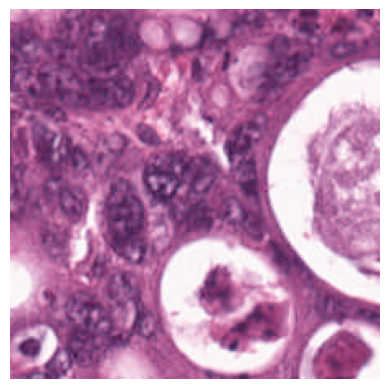

In [24]:
(img, label) = next(iter(q))
image = img[2]
show_image(image)

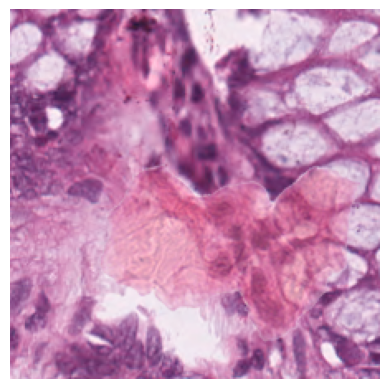

In [25]:
(img, label) = next(iter(p))
image = img[2]
show_image(image)

In [49]:
from pathlib import Path
data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")
l = data_setup_ood.ImageFolderCustom(data_path)

In [56]:
one = 0
for i in l.center:
    one += i == 4
one

20000

In [7]:
from typing import Type
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


def validate_step(
    model,
    loss_fn,
    validate_dataloader,
    device):

    model.eval()

    validate_loss, validate_acc = 0.0,0.0
    
    with torch.inference_mode():

        for batch, (x,y) in enumerate(validate_dataloader):
            x, y = x.to(device), y.to(device)

            y_pred_logits = model(x)

            loss = loss_fn(y_pred_logits, y)
            validate_loss += loss.item()

            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            validate_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)

    
    validate_loss /= len(validate_dataloader)
    validate_acc /= len(validate_dataloader)


    return validate_loss, validate_acc

def test_step(
    model,
    loss_fn,
    test_dataloader,
    device):

    model.eval()

    test_loss, test_acc = 0.0,0.0
    
    with torch.inference_mode():

        for batch, (x,y) in enumerate(test_dataloader):
            x, y = x.to(device), y.to(device)

            y_pred_logits = model(x)

            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)

    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)


    return test_loss, test_acc


def train_step(
    model,
    optimizer,
    loss_fn,
    train_dataloader,
    device    
    ):
    train_loss, train_acc = 0.0, 0.0
    for batch, (x,y) in enumerate(train_dataloader):
        x,y = x.to(device), y.to(device)
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    return train_loss, train_acc



def train_client(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        train_dataloader: Type[DataLoader],
        validate_dataloader: Type[DataLoader],
        device,
        epochs,
        writer = None,):

    results = {"train_loss": [],
            "train_acc": [],
            "validate_loss": [],
            "validate_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = train_step(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            train_dataloader=train_dataloader,
            device=device
        )

        validate_loss, validate_acc = validate_step(
            model=model,
            validate_dataloader=validate_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["validate_loss"].append(validate_loss)
        results["validate_acc"].append(validate_acc)


    return results, model

In [11]:
import copy
import torch
import torch.nn as nn
from typing import Type
import client
import data_setup_ood
from tqdm.auto import tqdm
import summary_writer
import aggregation_functions

fk = []
class Server:
    def __init__(self,
        num_train_clients: int, #number of training clients
        num_test_clients: int, #number of test clients out of total clients
        model: Type[nn.Module],
        loss_fn_type: Type[nn.Module],
        optimizer_type: Type[torch.optim.Optimizer],
        model_name,
        experiment_name,
        device,
        transform,
        lr
        ):

        self.num_train_clients = num_train_clients
        self.num_test_clients = num_test_clients
        self.model = model.to(device)
        self.experiment_info = {"model_name": model_name, "experiment_name": experiment_name}
        self.loss_fn_type = loss_fn_type
        self.optimizer_type = optimizer_type
        self.transform = transform
        self.train_dataloaders, self.validate_dataloaders, self.test_dataloaders = data_setup_ood.create_dataloaders(self.transform)
        self.lr = lr
        self.device = device
        self.client_models = []
        for i in range(num_train_clients):
            self.client_models.append(copy.deepcopy(model).to(device))

    
    def run(self,
        server_epochs,
        client_epochs,
        folder_path):

        # writer = summary_writer.get_summary_writer(
        #     experiment_name=self.experiment_info["experiment_name"],
        #     model_name=self.experiment_info["model_name"]
        # )

        for epoch in tqdm(range(server_epochs)):
            train_loss, validate_loss = 0,0
            train_acc, validate_acc = 0,0
            for j in range(self.num_train_clients):
                self.client_models[j].to(self.device)
                optimizer = self.optimizer_type(params=self.client_models[j].parameters(), lr=self.lr)
                results, new_model = client.train_client(
                    model=self.client_models[j],
                    loss_fn = self.loss_fn_type(),
                    optimizer = optimizer,
                    train_dataloader = self.train_dataloaders[j],
                    validate_dataloader = self.validate_dataloaders[j],
                    device = self.device,
                    epochs = client_epochs
                )
                self.client_models[j] = copy.deepcopy(new_model)
                # writer.add_scalar(f"train_loss/client-{j+1}", results["train_loss"][-1], epoch)
                # writer.add_scalar(f"train_acc/client-{j+1}", results["train_acc"][-1], epoch)
                # writer.add_scalar(f"validate_loss/client-{j+1}", results["validate_loss"][-1], epoch)
                # writer.add_scalar(f"validate_acc/client-{j+1}", results["validate_acc"][-1], epoch)

                train_loss += results["train_loss"][-1]
                validate_loss += results["validate_loss"][-1]
                train_acc += results["train_acc"][-1]
                validate_acc += results["validate_acc"][-1]

                p = folder_path/f"models/client-{j}/"
                p.mkdir(parents=True, exist_ok=True)
                file_path = p/f"epoch-{epoch}.pt"

                torch.save(obj=self.client_models[j].state_dict(), f=file_path)
            train_loss /= self.num_train_clients
            validate_loss /= self.num_train_clients
            train_acc /= self.num_train_clients
            validate_acc /= self.num_train_clients

            self.model = aggregation_functions.fed_avg(client_models=self.client_models, train_dataloaders=self.train_dataloaders)
            # self.model.load_state_dict(self.client_models[0].model.state_dict())
            # for j in range(1, self.num_train_clients):
            #     for(key, value) in self.model.state_dict().items():
            #         self.model.state_dict()[key].copy_(self.client_models[j].model.state_dict()[key] + value)
            
            # for (key, value) in self.model.state_dict().items():
            #     self.model.state_dict()[key].copy_(value/self.num_clients)

            for j in range(self.num_train_clients):
                self.client_models[j].load_state_dict(self.model.state_dict())
                self.client_models[j].to(self.device)
                
            
            
            final_loss, final_acc = 0,0
            for i in range(self.num_train_clients):
                temp_loss, temp_acc = client.validate_step(
                    model=self.client_models[i],
                    loss_fn=self.loss_fn_type(),
                    validate_dataloader=self.validate_dataloaders[i],
                    device=self.device
                )
                final_loss += temp_loss
                final_acc += temp_acc
            
            final_loss /= self.num_train_clients
            final_acc /= self.num_train_clients
            # writer.add_scalar("final_validate_loss/client", validate_loss, epoch)
            # writer.add_scalar("final_validate_acc/client", validate_acc, epoch)
            # writer.add_scalar("final_validate_loss/server", final_loss, epoch)
            # writer.add_scalar("final_validate_acc/server", final_acc, epoch)

            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"validate_loss: {validate_loss:.4f} | "
                f"validate_acc: {validate_acc:.4f}"
                "\n"
                "Aggregated Model"
                f"Epoch: {epoch+1} | "
                f"validate_loss: {final_loss:.4f} | "
                f"validate_acc: {final_acc:.4f}"
            )

            break
            # p = folder_path/"models/server/"
            # p.mkdir(parents = True, exist_ok = True)
            # p_file = p/f"epoch-{epoch}.pt"
            # torch.save(obj=self.model.state_dict(), f=p_file)
        # writer.close()

In [12]:
import server
from pathlib import Path
import torch
import torchvision

device = "cuda:0" if torch.cuda.is_available() else "cpu"

weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 1024, out_features = 9)
)



new_server = server.Server(
    num_train_clients=4,
    num_test_clients=1,
    loss_fn_type = torch.nn.CrossEntropyLoss,
    optimizer_type=torch.optim.Adam,
    model_name="DenseNet-121",
    experiment_name="FedAvg-client-1-server-10-center-ood-take-2",
    device=device,
    lr=0.001,
    model=model,
    transform=auto_transform
)


In [21]:
import os
root = Path(f"../FedAvg-client-1-server-10/models")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()
model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features = 1024, out_features = 9)
    )

model = model.to(device)

client_path = root/f"client-0/"
_,_,files = next(os.walk(client_path))
num_epochs = len(files)
model_path = client_path/f"epoch-{num_epochs-1}.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [22]:
validate_step(
    model,
    torch.nn.CrossEntropyLoss(),
    new_server.validate_dataloaders[0],
    device
)

(0.11421690096799285, 0.9605)

In [5]:
new_server.validate_dataloaders[0]

In [15]:
new_server.run(
    server_epochs=1,
    client_epochs=1,
    folder_path=Path("../FedAvg-client-1-server-10-center-ood-take-2")
)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5579 | train_acc: 0.8117 | validate_loss: 15.0922 | validate_acc: 0.2436
Aggregated ModelEpoch: 1 | validate_loss: 7.0197 | validate_acc: 0.0000


In [31]:
from typing import Dict, List, Tuple
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from pathlib import Path
import random
import numpy as np
from PIL import Image
import os
import froodo as fr

num_workers = 2
data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")
batch_size = 32
total_samples, num_samples = 0, 0
seed = 42
num_clients = 5
num_test_clients = 1


def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')
    
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx



class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        
        self.paths = list(Path(targ_dir).glob("*/*.tif")) # note: you'd have to update this if you've got .png's or .jpeg's
        # self.paths = np.random.permutation(self.paths)
        # Setup transforms

        self.train_client_indices = [0,1,2,3]
        self.ood_client_indices = [3]
        self.center = []

        total_samples = len(self.paths)
        num_samples = total_samples
        num_samples_per_client = int(num_samples/num_clients)

        for i in range(num_clients):
            self.center += [i]*num_samples_per_client
        
        self.center = np.random.permutation(self.center)


        # try:
        #     # print("whyg")
        #     self.center = torch.load(Path("../center.pt"))
        # except:
        #     regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        #     for idx in tqdm(range(len(self.paths))):
        #         image_path = self.paths[idx]
        #         mo=regex.search(str(image_path)[69:])
        #         patient,node,x,y = mo.groups()
        #         patient,node,x,y = int(patient), int(node), int(x), int(y)
        #         self.center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

        self.aug_types = [fr.DarkSpotsAugmentation(1), fr.FatAugmentation(1), fr.SquamousAugmentation(1), fr.ThreadAugmentation(1), fr.GaussianBlurAugmentation(sigma=5)]
        self.augs = []
        for i in range(len(self.center)):
            if self.center[i] in self.ood_client_indices:
                self.augs.append(np.random.choice(self.aug_types))
            else:
                self.augs.append(None)
        # self.augs = [random.choice(self.aug_types) if self.center[i] in self.ood_client_indices else None for i in range(len(self.center))]
                    # for idx in range(len(self.paths)):
        #     image_path = self.paths[idx]
        #     regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        #     mo=regex.search(str(image_path)[69:])
        #     patient,node,x,y = mo.groups()
        #     patient,node,x,y = int(patient), int(node), int(x), int(y)
        #     self.center[idx] = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0])


        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        img = Image.open(image_path)
        img_tensor = (torch.tensor(np.asarray(img).astype(np.float32)/255)).permute(2,0,1)[:3]
        if self.augs[index] is not None:
            modified_img_tensor = (self.augs[index](fr.Sample(img_tensor))).image
            modified_img_array = (modified_img_tensor.permute(1,2,0) * 255).numpy().astype(np.uint8)
        else:
            modified_img_array = (img_tensor.permute(1,2,0) * 255).numpy().astype(np.uint8)
        return Image.fromarray(modified_img_array)
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        # regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        # mo=regex.search(str(image_path)[69:])
        # # print(mo.groups())
        # patient,node,x,y = mo.groups()
        # patient,node,x,y = int(patient), int(node), int(x), int(y)

        # has_cancer = int(self.df[(self.df["patient"] == patient) & (self.df["node"] == node) & (self.df["x_coord"] == x) & (self.df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


def create_dataloaders(data_transform: transforms.Compose):
    # random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    data = ImageFolderCustom(
        targ_dir = data_path,
        transform = data_transform
    )
    # print(len(paths))
    # # Setup transforms
    # df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
    # regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
    # for idx in tqdm(range(len(paths))):
    #     image_path = paths[idx]
    #     mo=regex.search(str(image_path)[69:])
    #     patient,node,x,y = mo.groups()
    #     patient,node,x,y = int(patient), int(node), int(x), int(y)
    #     # center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

    indices_subsets = {0:[],1:[],2:[],3:[],4:[],}

    for i in range(len(data.center)):
        indices_subsets[data.center[i]].append(i)

    total_samples = len(data)
    num_samples = total_samples

    train_indices=[]
    validate_indices=[]
    test_indices=[]

    train_client_indices = [0,1,2,3]
    # ood_client_indices = [3]

    for i in range(num_clients):
        if(i in train_client_indices):
            train_split = int(0.8*len(indices_subsets[i]))
            train_indices.append(indices_subsets[i][0:train_split])
            validate_indices.append(indices_subsets[i][train_split:])
        else:
            test_indices.append(indices_subsets[i])

    train_datasets = []
    validate_datasets = []
    test_datasets = []

    tr_idx, te_idx = 0,0
    for i in range(num_clients):
        if(i in train_client_indices):
            train_datasets.append(Subset(data, train_indices[tr_idx]))
            validate_datasets.append(Subset(data, validate_indices[tr_idx]))
            tr_idx+=1
        else:
            test_datasets.append(Subset(data, test_indices[te_idx]))
            te_idx+=1
    
    train_dataloaders = []
    validate_dataloaders = []
    test_dataloaders = []

    tr_idx, te_idx = 0,0


    for i in range(num_clients):
        if(i in train_client_indices):
            train_dataloaders.append(
                DataLoader(
                    dataset = train_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
            ))

            validate_dataloaders.append(
                DataLoader(
                    dataset = validate_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )

            tr_idx += 1

        else:
            test_dataloaders.append(
                DataLoader(
                    dataset = test_datasets[te_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )
            te_idx += 1

    return train_dataloaders, validate_dataloaders, test_dataloaders


In [21]:
import torchvision
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()
model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features = 1024, out_features = 9)
    )

model = model.to(device)

In [32]:
data = ImageFolderCustom(
    targ_dir = data_path,
    transform = auto_transform
)


In [42]:
zero = []
for i in range(60000, 60100):
    print(data[i][1], end = "")
# for i in range(len(data.center)):
#     if data.center[i] == 3:
#         print(data[i][1])
# break

77

KeyboardInterrupt: 

In [1]:
from typing import Dict, List, Tuple
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from pathlib import Path
import numpy as np
from PIL import Image
import os
import froodo as fr

num_workers = 2
data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")
batch_size = 32
total_samples, num_samples = 0, 0
seed = 42
num_clients = 5
num_test_clients = 1


def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')
    
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx



class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        
        self.paths = list(Path(targ_dir).glob("*/*.tif")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms

        self.train_client_indices = [0,1,2,3]
        self.ood_client_indices = [3]
        self.center = []

        total_samples =len(self.paths)
        num_samples = total_samples
        num_samples_per_client = int(num_samples/num_clients)

        for i in range(num_clients):
            self.center += [i]*num_samples_per_client
        
        self.center = np.random.permutation(self.center)


        # try:
        #     # print("whyg")
        #     self.center = torch.load(Path("../center.pt"))
        # except:
        #     regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        #     for idx in tqdm(range(len(self.paths))):
        #         image_path = self.paths[idx]
        #         mo=regex.search(str(image_path)[69:])
        #         patient,node,x,y = mo.groups()
        #         patient,node,x,y = int(patient), int(node), int(x), int(y)
        #         self.center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

        self.aug_types = [fr.DarkSpotsAugmentation(1), fr.FatAugmentation(1), fr.SquamousAugmentation(1), fr.ThreadAugmentation(1), fr.GaussianBlurAugmentation(sigma=5)]
        self.augs = []
        for i in range(len(self.center)):
            if self.center[i] in self.ood_client_indices:
                self.augs.append(np.random.choice(self.aug_types))
            else:
                self.augs.append(None)
        # self.augs = [random.choice(self.aug_types) if self.center[i] in self.ood_client_indices else None for i in range(len(self.center))]
                    # for idx in range(len(self.paths)):
        #     image_path = self.paths[idx]
        #     regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        #     mo=regex.search(str(image_path)[69:])
        #     patient,node,x,y = mo.groups()
        #     patient,node,x,y = int(patient), int(node), int(x), int(y)
        #     self.center[idx] = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0])


        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        img = Image.open(image_path)
        img_tensor = (torch.tensor(np.asarray(img).astype(np.float32)/255)).permute(2,0,1)[:3]
        if self.augs[index] is not None:
            modified_img_tensor = (self.augs[index](fr.Sample(img_tensor))).image
            modified_img_array = (modified_img_tensor.permute(1,2,0) * 255).numpy().astype(np.uint8)
        else:
            modified_img_array = (img_tensor.permute(1,2,0) * 255).numpy().astype(np.uint8)
        return Image.fromarray(modified_img_array)
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        # regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        # mo=regex.search(str(image_path)[69:])
        # # print(mo.groups())
        # patient,node,x,y = mo.groups()
        # patient,node,x,y = int(patient), int(node), int(x), int(y)

        # has_cancer = int(self.df[(self.df["patient"] == patient) & (self.df["node"] == node) & (self.df["x_coord"] == x) & (self.df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


def create_dataloaders(data_transform: transforms.Compose):
    # random.seed(seed)
    np.random.seed(seed)

    data = ImageFolderCustom(
        targ_dir = data_path,
        transform = data_transform
    )
    # print(len(paths))
    # # Setup transforms
    # df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
    # regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
    # for idx in tqdm(range(len(paths))):
    #     image_path = paths[idx]
    #     mo=regex.search(str(image_path)[69:])
    #     patient,node,x,y = mo.groups()
    #     patient,node,x,y = int(patient), int(node), int(x), int(y)
    #     # center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

    indices_subsets = {0:[],1:[],2:[],3:[],4:[],}

    for i in range(len(data.center)):
        indices_subsets[data.center[i]].append(i)

    for (key, value) in indices_subsets.items():
        indices_subsets[key] = np.random.permutation(indices_subsets[key])


    total_samples = len(data)
    num_samples = total_samples

    train_indices=[]
    validate_indices=[]
    test_indices=[]

    train_client_indices = [0,1,2,3]
    # ood_client_indices = [3]

    for i in range(num_clients):
        if(i in train_client_indices):
            train_split = int(0.8*len(indices_subsets[i]))
            train_indices.append(indices_subsets[i][0:train_split])
            validate_indices.append(indices_subsets[i][train_split:])
        else:
            test_indices.append(indices_subsets[i])

    train_datasets = []
    validate_datasets = []
    test_datasets = []

    tr_idx, te_idx = 0,0
    for i in range(num_clients):
        if(i in train_client_indices):
            train_datasets.append(Subset(data, train_indices[tr_idx]))
            validate_datasets.append(Subset(data, validate_indices[tr_idx]))
            tr_idx+=1
        else:
            test_datasets.append(Subset(data, test_indices[te_idx]))
            te_idx+=1
    
    train_dataloaders = []
    validate_dataloaders = []
    test_dataloaders = []

    tr_idx, te_idx = 0,0


    for i in range(num_clients):
        if(i in train_client_indices):
            train_dataloaders.append(
                DataLoader(
                    dataset = train_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
            ))

            validate_dataloaders.append(
                DataLoader(
                    dataset = validate_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )

            tr_idx += 1

        else:
            test_dataloaders.append(
                DataLoader(
                    dataset = test_datasets[te_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )
            te_idx += 1

    return train_dataloaders, validate_dataloaders, test_dataloaders


In [6]:
import torchvision
np.random.seed(seed)

data = ImageFolderCustom(
    targ_dir = data_path,
    transform = torchvision.transforms.ToTensor()
)
# print(len(paths))
# # Setup transforms
# df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
# regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
# for idx in tqdm(range(len(paths))):
#     image_path = paths[idx]
#     mo=regex.search(str(image_path)[69:])
#     patient,node,x,y = mo.groups()
#     patient,node,x,y = int(patient), int(node), int(x), int(y)
#     # center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

indices_subsets = {0:[],1:[],2:[],3:[],4:[],}

for i in range(len(data.center)):
    indices_subsets[data.center[i]].append(i)
print(indices_subsets[0][-1:-50:-1])
old = indices_subsets[0]
for (key, value) in indices_subsets.items():
    indices_subsets[key] = np.random.permutation(indices_subsets[key])
print(indices_subsets[0][:50])

print(sorted(indices_subsets[0]) == sorted(old))

[99999, 99998, 99995, 99989, 99985, 99980, 99971, 99970, 99961, 99959, 99954, 99953, 99945, 99938, 99932, 99923, 99919, 99911, 99909, 99905, 99899, 99896, 99894, 99890, 99888, 99886, 99881, 99870, 99866, 99860, 99858, 99850, 99834, 99826, 99823, 99816, 99813, 99810, 99808, 99805, 99782, 99779, 99768, 99753, 99750, 99745, 99744, 99741, 99736]
[ 7668 17377   551 15906 47465 20513 41210 72184 39942 81447 82573 65336
 68556 41860 71133 53587 13954 10342 48647 98628 12783 82855 51559 35234
 65172  2467 36128 35246 55218 45463 10067 18638 14689 63468 20268 76406
 81439 66341 38770 45961 33020 41694 79859 36257 84256  9177 78847 88867
 68574 55023]
True


## Mahalanobis distance with Generative models

In [42]:
from pathlib import Path
import torch
import torchvision
from tqdm.auto import tqdm
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights)
auto_transform = weights.transforms()
fail = 0

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 1024, out_features = 9)
)


folder_path = Path("../FedAvg-client-1-server-10-ood-severe/models")

distribution_clients = [0, 1]
test_clients = [2,3]

client_paths = [folder_path/f"client-{i}" for i in distribution_clients + test_clients]
server_path = folder_path/"server"

_,_,files = next(os.walk(client_paths[0]))
epochs = len(files)
for i in client_paths:
    _,_,files = next(os.walk(i))
    assert(len(files) == epochs)
_,_,files = next(os.walk(server_path))
assert(len(files) == epochs)

fin_mahal = []

In [44]:
import copy 

ep = 0
client_models = [copy.deepcopy(model) for j in range(len(client_paths))]
for i in range(len(client_models)):
    client_models[i].load_state_dict(torch.load(client_paths[i]/f"epoch-{ep}.pt", map_location = device))
server_model = copy.deepcopy(model)
server_model.load_state_dict(torch.load(server_path/f"epoch-{ep}.pt", map_location = device))


<All keys matched successfully>

In [ ]:
flatten_layer = nn.Flatten(start_dim = 0)
mahal_dis = {}

for i in test_clients:
    mahal_dis[i] = []

    for(key, value) in tqdm(client_models[0].state_dict().items(), ncols=0):
        try:
            torch.cuda.empty_cache()
            if(value.shape == torch.Size([])):
                continue
            
            data = torch.tensor(data).to(device)
            y_mu = torch.mean(data, axis = 0).to(device)
            cov = torch.cov(data.T).to(device)

            del data
            torch.cuda.empty_cache()
            test_data = np.array()

            test_data = np.array([flatten_layer(client_models[i].state_dict()[key]).numpy() for i in test_clients])
            test_data = test_data.astype(np.float32)
            test_data = torch.tensor(test_data).to(device)
            test_new = (test_data - y_mu.unsqueeze(0)).to(device)


In [53]:
import numpy as np
import torch.nn as nn
flatten_layer = nn.Flatten(start_dim = 0)

key = list(client_models[0].state_dict().items())[200][0]
data = np.array([flatten_layer(client_models[i].state_dict()[key]).numpy() for i in distribution_clients])

In [54]:
data[0].shape

(128,)

In [63]:
new_data = []
sd = np.std(data, axis = 0)
for i in range(len(data)):
    new_data.extend(data[i]+0.01*np.random.multivariate_normal(np.zeros_like(data[0]), np.eye(data[0].shape[0]), 2500))

In [64]:
new_data = torch.tensor(np.array(new_data)).to(device)

In [65]:
y_mu = torch.mean(new_data, axis = 0).to(device)
cov = torch.cov(new_data.T).to(device)

In [66]:
inv_cov = torch.linalg.inv(cov)
mahal_dis = {}

test_clients = [0,1,2,3]
for i in test_clients:
    mahal_dis[i] = []


test_data = np.array([flatten_layer(client_models[i].state_dict()[key]).numpy() for i in test_clients])
test_data = test_data.astype(np.float32)
test_data = torch.tensor(test_data).to(device)
test_new = (test_data - y_mu.unsqueeze(0)).to(device)
torch.cuda.empty_cache()

mahal = torch.mm(test_new, torch.mm(inv_cov, test_new.T))
for i in range(len(test_clients)):
    mahal_dis[test_clients[i]].append(mahal[i][i].item())

mahal_dis

{0: [1.0550296549077256],
 1: [1.0491490064648419],
 2: [976.5398014558547],
 3: [1087.0256889190741]}

In [36]:
mahal_dis

{2: [2717.8272288479193], 3: [6122.96108810733]}

In [43]:
np.random.multivariate_normal(np.zeros_like(data[0]), np.identity(data[0].shape[0]), 2500).shape

(2500, 128)

In [69]:
sd = np.std(data, axis = 0)

In [88]:
data[0]+np.random.multivariate_normal(np.zeros_like(data[0]), np.diag(0.01*sd), 2500)

array([[0.12499897, 0.11346163, 0.14059903, ..., 0.17587864, 0.09918279,
        0.19994597],
       [0.13498596, 0.09919168, 0.15553055, ..., 0.18121262, 0.09962398,
        0.18968244],
       [0.12775838, 0.12600001, 0.13799273, ..., 0.16494846, 0.09942348,
        0.1958304 ],
       ...,
       [0.13765764, 0.10776766, 0.1528626 , ..., 0.18173552, 0.09966125,
        0.20180781],
       [0.12681524, 0.10397895, 0.15377159, ..., 0.16487246, 0.09903898,
        0.20275705],
       [0.12942211, 0.1121329 , 0.14881314, ..., 0.1731008 , 0.09950396,
        0.19262992]])

In [81]:
data[0]

array([ 1.31742835e-01,  1.13974929e-01,  1.43914685e-01,  1.20162152e-01,
        1.28526747e-01,  1.35576040e-01,  6.10315315e-02,  9.02089477e-02,
        5.39390115e-08,  1.13063343e-01,  1.62094086e-01,  1.00874551e-01,
        1.35626033e-01,  8.30108225e-02,  2.44161747e-02,  3.98857880e-09,
        1.04432791e-01, -2.91102100e-03,  3.81025821e-02,  1.11934491e-01,
        8.74494463e-02,  1.03995726e-01,  1.22679003e-01,  2.06999518e-02,
        1.45795271e-01,  8.76297727e-02,  7.91798458e-02,  9.44509134e-02,
        8.69565085e-02,  8.45291167e-02,  1.00960039e-01,  7.13357702e-02,
        9.58239660e-02,  1.17025048e-01,  1.57927886e-01,  1.23788096e-01,
        8.20442885e-02,  1.10833742e-01,  1.07251175e-01,  8.68675634e-02,
        1.06399953e-01,  2.46452726e-03,  1.01560928e-01,  8.74677524e-02,
        1.81302011e-01,  7.95851424e-02,  1.18015006e-01,  7.03876838e-02,
        1.51610017e-01,  8.81443247e-02,  2.01840609e-01,  8.52878913e-02,
        1.06794402e-01,  

In [35]:
import data_setup_ood_dark
import torchvision

f = data_setup_ood_dark.create_dataloaders(
    torchvision.transforms.ToTensor(),
)
(img, label) = next(iter(f[0][6]))

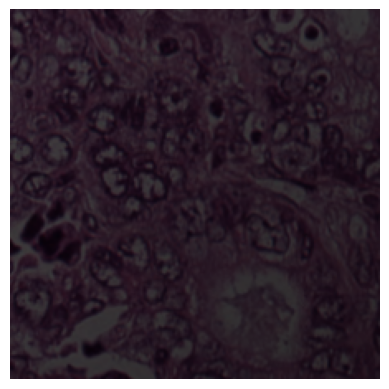

In [37]:
image = img[1]
show_image(image)